In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
def median_filter(img: np.array) -> np.array:
  row, col = img.shape
  output_img = np.zeros(shape = [row,col])
  for i in range(1, row-1):
    for j in range(1,col-1):
       temp = [img[i-1, j-1],
               img[i-1, j],
               img[i-1, j + 1],
               img[i, j-1],
               img[i, j],
               img[i, j + 1],
               img[i + 1, j-1],
               img[i + 1, j],
               img[i + 1, j + 1]]
       new = sorted(temp)
       output_img[i,j]= temp[4] 
  return output_img

In [3]:
def slice(mat):
  oroc = mat[::2,::2]
  orec = mat[::2,1::2]
  eroc = mat[1::2,::2]
  erec = mat[1::2,1::2]

  return oroc, orec, eroc, erec

In [19]:
def YCbCr(im):
  #Slicing the first 10 rows and last 13 rows and 1st coloumn
  img = im[10:370,1:962]

  #Making of Y component
  field1 = img[:,0:960]
  field2 = img[:,1:961]
  Y =(field1+field2)/2

  #Making of Cb and Cr
  #Slicing the image in ever, odd rows and columns
  oroc, orec, eroc, erec = slice(img)

  #Apllying median filter to different
  med_oroc = median_filter(oroc)
  med_orec = median_filter(orec)
  med_eroc = median_filter(eroc)
  med_erec = median_filter(erec)

  #Merging the median filtered cells to one image
  med_filt_img = np.zeros(shape=(360,961))
  med_filt_img[::2,::2] = med_oroc
  med_filt_img[::2,1::2] = med_orec
  med_filt_img[1::2,::2] = med_eroc
  med_filt_img[1::2,1::2] = med_erec

  #Shaping it into 360,960 from 360,961
  field01 = med_filt_img[:,0:960]
  field02 = med_filt_img[:,1:961]
  CbCr =((field01-field02))

  #Multiplying sing matrix
  sing_mat = np.ones((360,960))
  oroc1, orec1, eroc1, erec1  = slice(sing_mat)

  orec1 *=(-1)
  eroc1 *=(-1)

  zero_mat = np.zeros((360,960))
  zero_mat[::2,::2] += oroc1
  zero_mat[::2,1::2] += orec1
  zero_mat[1::2,::2] += eroc1
  zero_mat[1::2,1::2] += erec1
  

  sign_multiplied = (zero_mat * CbCr)
  # print(sign_multiplied.max(), sign_multiplied.min())

  #Splitting it in Cb and Cr
  cb = sign_multiplied[::2,::]
  cr = sign_multiplied[1::2,::]
  print(cr.shape)

  return Y,cb,cr 

In [20]:
raw  = open('/content/drive/MyDrive/Colab Notebooks/1_raw.txt','r')
rows = 383
cols = 962
f = np.fromfile(raw, dtype=np.uint16, count = rows*cols)
image = f.reshape((rows, cols))

#normalizing values from 0-255
# mn = image.min()
# mx = image.max()
# mx -= mn
# image = ((image - mn)/(mx)) * 255
y,cb,cr = YCbCr(image)

(180, 960)


In [21]:
print(y.min(), y.max(), y.dtype)
print(cr.min(), cr.max(), cr.dtype)
print(cb.min(), cb.max(), cb.dtype)

#Hence y,cb,cr cannot be just displayed. it should be normalized in range 0-255

709.0 7575.5 float64
-2744.0 650.0 float64
-936.0 2911.0 float64


(<matplotlib.axes._subplots.AxesSubplot at 0x7f183e85a750>,
 Text(0.5, 1.0, 'Cr'),
 (-0.5, 959.5, 179.5, -0.5))

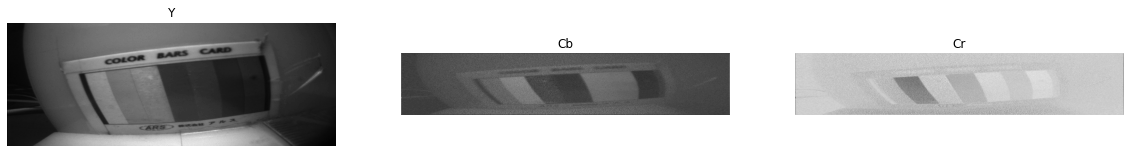

In [22]:
#normalizing values from 0-255 only to view the y,cb,cr images
mn = y.min()
mx = y.max()
mx -= mn
y1 = ((y - mn)/(mx)) * 255

cr1 = cr + cr.min()
mn1 = cr.min()
mx1 = cr.max()
mx1 -= mn1
cr1 = ((cr1 - mn1)/(mx1)) * 255

cb1 = cb + cb.min()
mn2 = cb.min()
mx2 = cb.max()
mx2 -= mn2
cb1 = ((cb1 - mn2)/(mx2)) * 255

plt.figure(figsize=(20,5))
plt.subplot(131), plt.imshow(y1, cmap='gray'), plt.title('Y'), plt.axis('off')
plt.subplot(132), plt.imshow(cb1, cmap='gray'), plt.title('Cb'), plt.axis('off')
plt.subplot(133), plt.imshow(cr1, cmap='gray'), plt.title('Cr'), plt.axis('off')


In [23]:
#bicubic interpolation of y plane
y_resized = cv2.resize(y, None,  fx=1, fy=2, interpolation=cv2.INTER_CUBIC).astype(np.uint16)

#nearest neighbour interpolation of cb,cr
cb_resized = cv2.resize(cb, None,  fx=1, fy=4, interpolation=cv2.INTER_NEAREST).astype(np.uint16)
cr_resized = cv2.resize(cr, None,  fx=1, fy=4, interpolation=cv2.INTER_NEAREST).astype(np.uint16)

In [24]:
print(y_resized.min(), y_resized.max(), y_resized.dtype)
print(cr_resized.min(), cr_resized.max(), cr_resized.dtype)
print(cb_resized.min(), cb_resized.max(), cb_resized.dtype)

#Images can be viewd seperately but not as merged because y is in uint16 and cb,cr is in float64

715 7655 uint16
0 65535 uint16
0 65535 uint16


In [30]:
r = (y_resized + (1.13983 * cr_resized))
g = (y_resized + (-0.39465 * cb_resized - 0.58060 * cr_resized))
b = (y_resized + (2.03211 * cb_resized - 0.506 * cr_resized))

In [31]:
#YCbCr2RGB
yo = ((y_resized/16383)*255).astype(np.uint8)
cro = ((y_resized/16383)*255).astype(np.uint8)
cbo = ((y_resized/16383)*255).astype(np.uint8)

print(yo.min(), yo.max(), yo.dtype)
print(cro.min(), cro.max(), cro.dtype)
print(cbo.min(), cbo.max(), cbo.dtype)

#All values are now in 11.12 to 119.14 and float 64 dtype

11 119 uint8
11 119 uint8
11 119 uint8


In [26]:
#Normalizing yo,cbo,cro in range 0-255 and merging to view in rgb

mn2 = yo.min()
mx2 = yo.max()
mx2 -= mn2
y2 = ((yo - mn2)/(mx2)) * 255

mn2 = cro.min()
mx2 = cro.max()
mx2 -= mn2
cr2 = ((cro - mn2)/(mx2)) * 255


mn2 = cb.min()
mx2 = cb.max()
mx2 -= mn2
cb2 = ((cbo - mn2)/(mx2)) * 255

In [27]:
r = (yo + (1.13983 * cro))
g = (yo + (-0.39465 * cbo - 0.58060 * cro))
b = (yo + (2.03211 * cbo - 0.506 * cro))

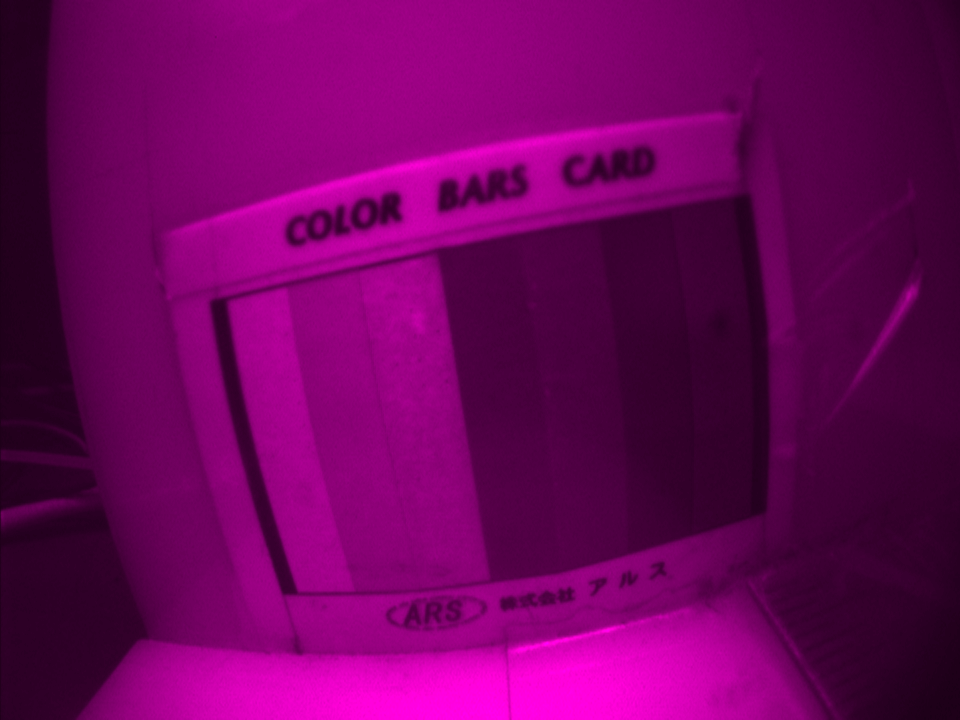

In [29]:
rgb1 = cv2.merge([r,g,b])
cv2_imshow(rgb1)

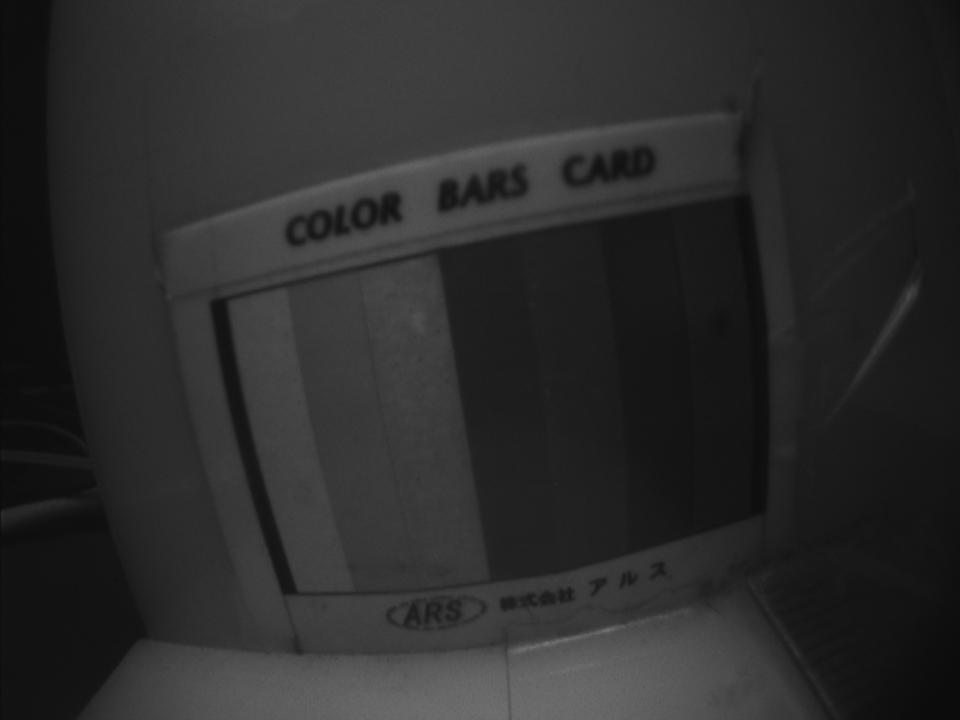

In [27]:
#Merging rgb
rgb = np.zeros((720,960,3))

rgb[:,:,0] = yo
rgb[:,:,1] = cbo
rgb[:,:,2] = cro

cv2_imshow(rgb)

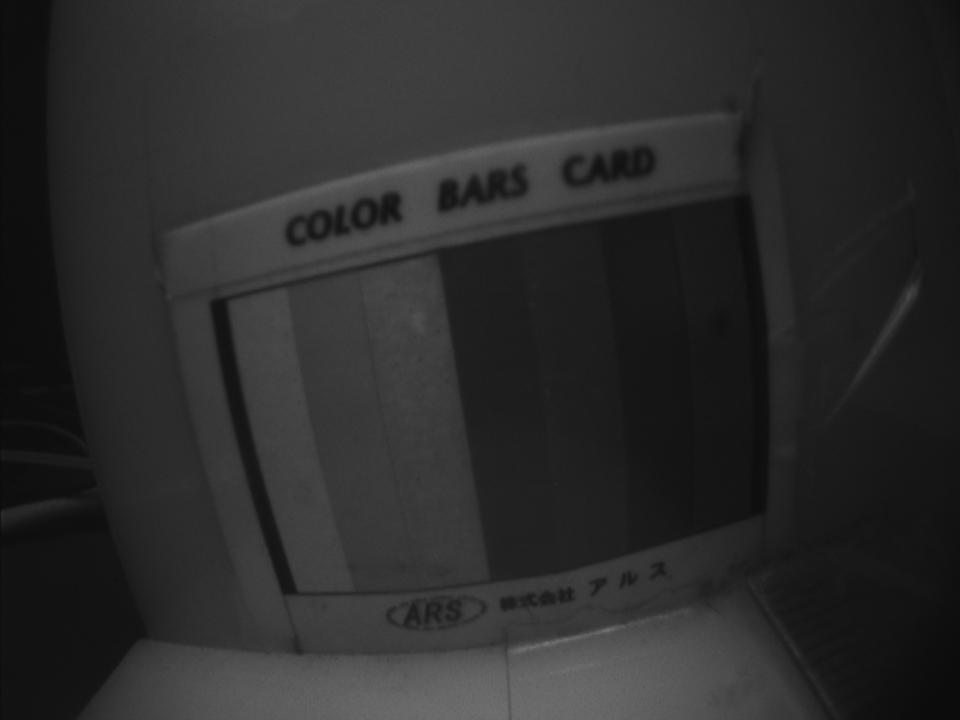

In [29]:
rgb[:,:,0] = yo
rgb[:,:,2] = cbo
rgb[:,:,1] = cro

cv2_imshow(rgb)

In [ ]:
# rav = num.ravel()
# for i in range(len(rav)):
#   if (i%2==0):
#     rav[i] *= (-1)
# ra=rav.reshape(6,6) 
# print(ra)

#this method does not work when cols are even

[[-1.  1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.  1.]]


In [ ]:
sing_mat = np.ones((6,6))

oroc = sing_mat[::2,::2]
erec = sing_mat[1::2,1::2]

orec = sing_mat[::2,1::2]
eroc = sing_mat[1::2,::2] 

oroc *=(-1)
erec *=(-1)

zero_mat = np.zeros((6,6))
zero_mat[::2,::2] += oroc
zero_mat[1::2,1::2] += erec
zero_mat[::2,1::2] += orec
zero_mat[1::2,::2] += eroc

print(zero_mat)

#the other matrix is orec, eroc *=-1

[[-1.  1. -1.  1. -1.  1.]
 [ 1. -1.  1. -1.  1. -1.]
 [-1.  1. -1.  1. -1.  1.]
 [ 1. -1.  1. -1.  1. -1.]
 [-1.  1. -1.  1. -1.  1.]
 [ 1. -1.  1. -1.  1. -1.]]
